In [1]:
import sys ; sys.path.append("../")
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import cvlib
import time

%matplotlib inline
%load_ext cython

In [83]:
img = cv.imread('shop.jpeg', cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
kernel = np.array([[-1, -1, -1], [-1, 9.5, -1], [-1, -1, -1]])
#img_sharpen = sharpen(img=img, kernel=kernel)

In [23]:
img.shape

(625, 940, 3)

### Caso incial

In [3]:
%%cython -a
import numpy as np
def sharpen(img:np.array, kernel:np.array):
    
    # Get the height, width, and number of channels of the image
    height,width,c =img.shape[0],img.shape[1],img.shape[2]
    
    # Get the height, width, and number of channels of the kernel
    kernel_height,kernel_width = kernel.shape[0],kernel.shape[1]
    
    # Create a new image of original img size minus the border 
    # where the convolution can't be applied
    new_img = np.zeros((height-kernel_height+1,width-kernel_width+1,3)) 
    
    # Loop through each pixel in the image
    # But skip the outer edges of the image
    for i in range(kernel_height//2, height-kernel_height//2-1):
        for j in range(kernel_width//2, width-kernel_width//2-1):
            # Extract a window of pixels around the current pixel
            window = img[i-kernel_height//2 : i+kernel_height//2+1,j-kernel_width//2 : j+kernel_width//2+1]
            # Apply the convolution to the window and set the result as the value of the current pixel in the new image
            var = np.absolute(int((window[:,:,0] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 0] = int(255)
            else:
                new_img[i, j, 0] = var
            var = np.absolute(int((window[:,:,1] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 1] = int(255)
            else:
                new_img[i, j, 1] = var
            var = np.absolute(int((window[:,:,2] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 2] = int(255)
            else:
                new_img[i, j, 2] = var
    return new_img.astype(np.uint8)

In [4]:
%timeit sharpen(img, kernel)

3.78 s ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Caso 2

In [80]:
%%cython -a
import cython
import numpy as np
@cython.boundscheck(False)
cpdef unsigned char[:, :,:] sharpen_cython(unsigned char[:, :,:] img, double[:, :] kernel):
    cdef int kernel_height, kernel_width, x, y, R, height, width, c, i , j, t, z
    # cdef unsigned char[:, :,] new_img
    # Get the height, width, and number of channels of the image
    height,width,c =img.shape[0],img.shape[1],img.shape[2]
    
    # Get the height, width, and number of channels of the kernel
    kernel_height,kernel_width = kernel.shape[0],kernel.shape[1]
    
    # Create a new image of original img size minus the border 
    # where the convolution can't be applied
    #cdef np.ndarray[FTYPE_t, ndim=2, mode='c'] new_img
    new_img = np.zeros((height-kernel_height+1,width-kernel_width+1,3)) 
    R = kernel_height//2
    # Loop through each pixel in the image
    # But skip the outer edges of the image
    for i in range(R, height-R-1):
        for j in range(R, width-R-1):
            # Extract a window of pixels around the current pixel
            window = img[i-R : i+R+1,j-R: j+R+1]
            # Apply the convolution to the window and set the result as the value of the current pixel in the new image
            for z in range(c):
                t = 0
                for x in range(kernel_height):
                    for y in range(kernel_width):
                            t += int(window[x, y,z] * kernel[x, y])
                #t = t if t>0 else (t*-1)
                t = abs((t))
                if (t > 255):
                    t = 255
                new_img[i,j,z] = t
    return new_img.astype(np.uint8)

Content of stderr:
/Users/carlosalvarado/.cache/ipython/cython/_cython_magic_f2508e2b56499638592a302196ee8129be74051f.c:3846:3: warning: code will never be executed [-Wunreachable-code]
  goto __pyx_L3_error;
  ^~~~~~~~~~~~~~~~~~~
/Users/carlosalvarado/.cache/ipython/cython/_cython_magic_f2508e2b56499638592a302196ee8129be74051f.c:5341:3: warning: code will never be executed [-Wunreachable-code]
  goto __pyx_L3_error;
  ^~~~~~~~~~~~~~~~~~~
/Users/carlosalvarado/.cache/ipython/cython/_cython_magic_f2508e2b56499638592a302196ee8129be74051f.c:5463:3: warning: code will never be executed [-Wunreachable-code]
  goto __pyx_L3_error;
  ^~~~~~~~~~~~~~~~~~~
/Users/carlosalvarado/.cache/ipython/cython/_cython_magic_f2508e2b56499638592a302196ee8129be74051f.c:5917:3: warning: code will never be executed [-Wunreachable-code]
  goto __pyx_L3_error;
  ^~~~~~~~~~~~~~~~~~~
/Users/carlosalvarado/.cache/ipython/cython/_cython_magic_f2508e2b56499638592a302196ee8129be74051f.c:6073:3: warning: code will never

In [84]:
%timeit sharpen_cython(img, kernel)

611 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Pruebas

In [7]:
def sharpen(img:np.array, kernel:np.array):
    
    # Get the height, width, and number of channels of the image
    height,width,c =img.shape[0],img.shape[1],img.shape[2]
    
    # Get the height, width, and number of channels of the kernel
    kernel_height,kernel_width = kernel.shape[0],kernel.shape[1]
    
    # Create a new image of original img size minus the border 
    # where the convolution can't be applied
    new_img = np.zeros((height-kernel_height+1,width-kernel_width+1,3)) 
    
    # Loop through each pixel in the image
    # But skip the outer edges of the image
    for i in range(kernel_height//2, height-kernel_height//2-1):
        for j in range(kernel_width//2, width-kernel_width//2-1):
            # Extract a window of pixels around the current pixel
            window = img[i-kernel_height//2 : i+kernel_height//2+1,j-kernel_width//2 : j+kernel_width//2+1]
            # Apply the convolution to the window and set the result as the value of the current pixel in the new image
            var = np.absolute(int((window[:,:,0] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 0] = int(255)
            else:
                new_img[i, j, 0] = var
            var = np.absolute(int((window[:,:,1] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 1] = int(255)
            else:
                new_img[i, j, 1] = var
            var = np.absolute(int((window[:,:,2] * kernel).sum()))
            if (var > 255):
                new_img[i, j, 2] = int(255)
            else:
                new_img[i, j, 2] = var
      
    # Clip values to the range 0-255
    #new_img = np.clip(new_img, 0, 255)
    return new_img.astype(np.uint8)

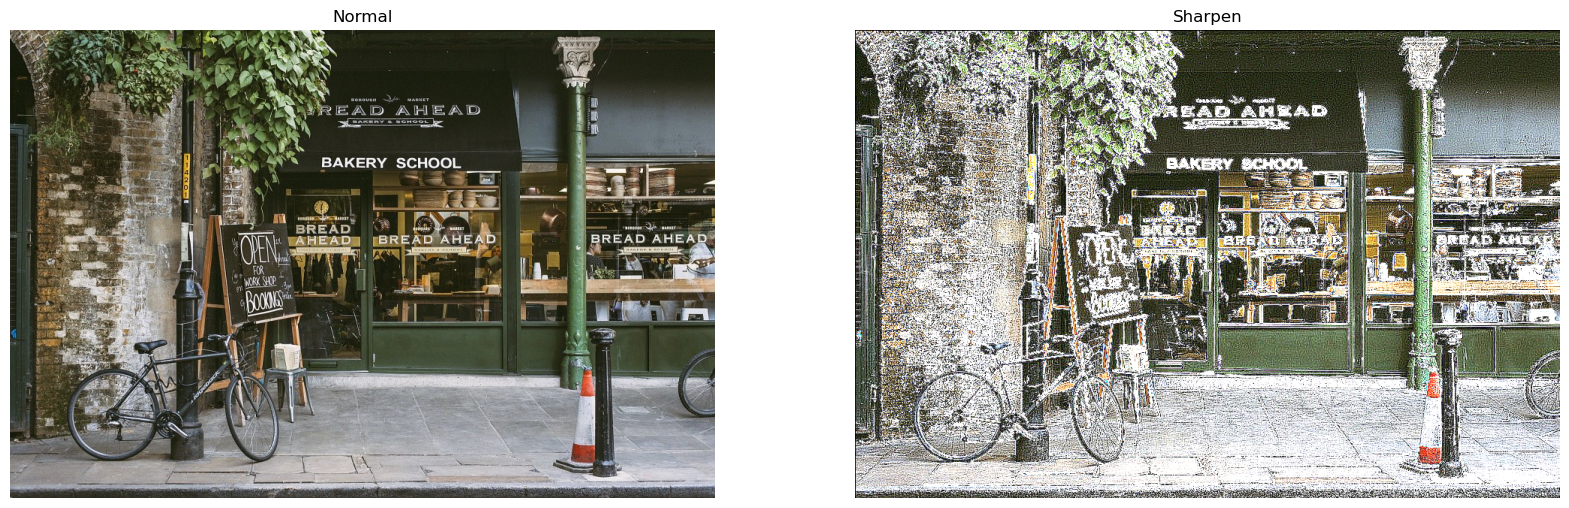

In [85]:
img_sharpen = sharpen_cython(img=img.copy(), kernel=kernel)
cvlib.imgcmp(img, img_sharpen, ["Normal", "Sharpen"])